In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pickle
import yaml

import sys
sys.path.append("../")
from models import DiscreteNAM, NAM
from utils import discretize, get_dataset, get_bin_counts, get_discetized_run_data, get_run_data

sys.path.append("../run_scripts")
from epoch_functions import train_epoch_nam_pairs, test_epoch_nam_pairs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def get_preds_discrete_nam_(dataset, seed, split):
    
    # Read in model
    model = torch.load(f"../model_saves/discrete_nam_{dataset}_seed{seed}_split{split}.pt")
    
    # Read in args using yaml
    args_id = model.params_id
    with open(f"../run_parameters/discrete_nam_{dataset}_seed{seed}_split{split}_params{args_id}.yaml", "r") as f:
        args = yaml.safe_load(f)
    
    
    data_dict = \
        get_discetized_run_data(dataset, seed=seed, split=split, max_bins=args["max_bins"], use_feature_set=False)
    
    X_test_discrete = data_dict["X_test_discrete"]
    y_test = data_dict["y_test"]
    
    selected_pairs = model.pairs_list.cpu().numpy()
    X_test_interactions = X_test_discrete.values[:, selected_pairs]

    batch_size = args["batch_size"]

    test_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_test_discrete.values),
        torch.FloatTensor(X_test_interactions), 
        torch.FloatTensor(y_test),
    )
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    _, preds = test_epoch_nam_pairs(model, test_loader, model_mains=model)
    return preds, y_test

In [7]:
def get_preds_discrete_nam(dataset, seed):
    
    splits = [1, 2, 3, 4, 5]
    
    preds = 0
    for split in splits:
        split_preds, y_test = get_preds_discrete_nam_(dataset, seed, split)
        preds += split_preds
        
    preds = preds / len(splits)
    return torch.sigmoid(preds).cpu().numpy(), y_test

In [8]:
def get_preds_ebm(dataset, seed):
    
    # Read in model
    with open(f"../model_saves/ebm_{dataset}_seed{seed}.pkl", "rb") as f:
        ebm = pickle.load(f)
    
    # Split doesn't matter because test data is the same
    data_dict = get_run_data(dataset, split=1, preprocess=False)
    X_test = data_dict["X_test"]
    
    preds = ebm.predict_proba(X_test)[:, 1]
    return preds, data_dict["y_test"]

In [9]:
def get_calibration_data(y_pred, y_test, n_bins = 10):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred, n_bins=n_bins, strategy="quantile")
    return fraction_of_positives, mean_predicted_value

EBM


Discrete_NAM


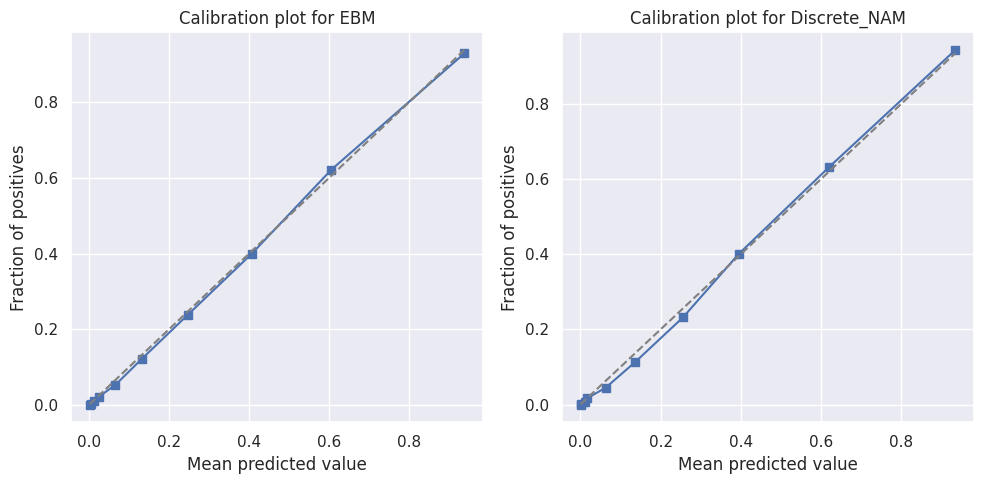

In [15]:
dataset = "adult"
models = ["EBM", "Discrete_NAM"]
seed = 10

fig, axes = plt.subplots(1, len(models), figsize=(10, 5))

for model, ax in zip(models, axes):
    if model == "EBM":
        preds, y_test = get_preds_ebm(dataset, seed)
    elif model == "Discrete_NAM":
        preds, y_test = get_preds_discrete_nam(dataset, seed)
    
    else:
        
        continue
    
    bin_pred_means, bin_props = get_calibration_data(preds, y_test)
    
    ax.plot(bin_pred_means, bin_props, "s-")
    ax.plot([bin_pred_means.min(), bin_pred_means.max()], [bin_pred_means.min(), bin_pred_means.max()], "--", color="gray")
    ax.set_title(f"Calibration plot for {model}")
    ax.set_xlabel('Mean predicted value')
    ax.set_ylabel('Fraction of positives') 
    
plt.tight_layout()
        